In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

In [2]:
import FinanceDataReader as fdr

# 삼성전자

In [3]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2022-01-01', '2023-12-31')
df.tail

<bound method NDFrame.tail of              Open   High    Low  Close    Volume    Change
Date                                                      
2022-01-03  79400  79800  78200  78600  13502112  0.003831
2022-01-04  78800  79200  78300  78700  12427416  0.001272
2022-01-05  78800  79000  76400  77400  25470640 -0.016518
2022-01-06  76700  77600  76600  76900  12931954 -0.006460
2022-01-07  78100  78400  77400  78300  15163757  0.018205
...           ...    ...    ...    ...       ...       ...
2023-12-21  74600  75000  74300  75000  13478766  0.002674
2023-12-22  75800  76300  75400  75900  14515608  0.012000
2023-12-26  76100  76700  75700  76600  13164909  0.009223
2023-12-27  76700  78000  76500  78000  20651042  0.018277
2023-12-28  77700  78500  77500  78500  17797536  0.006410

[491 rows x 6 columns]>

# 분석 코드

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

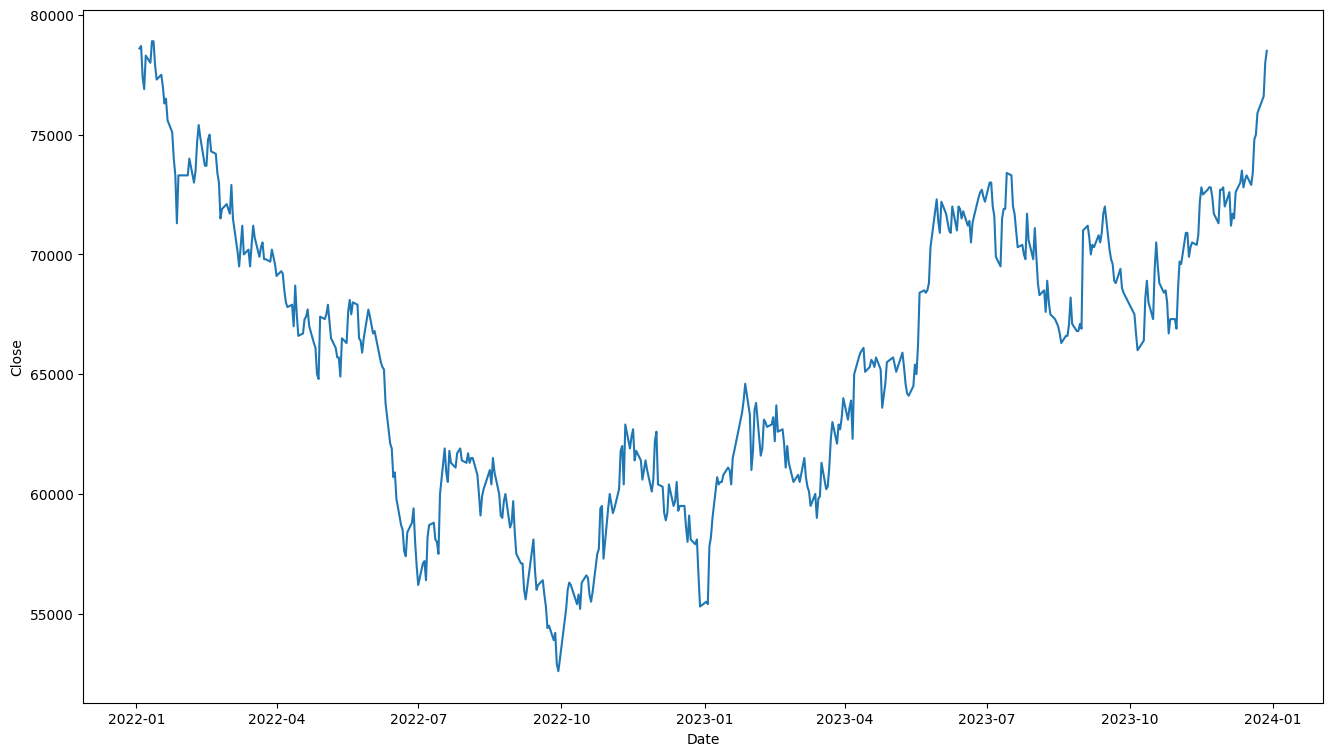

In [6]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [7]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [8]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [9]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

<ipython-input-8-650847349e00>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([286, 5, 4]) torch.Size([286, 1])


In [10]:
x_train_seq

tensor([[[0.9963, 1.0000, 0.9851, 0.2404],
         [0.9743, 0.9771, 0.9888, 0.2070],
         [0.9743, 0.9695, 0.9179, 0.6124],
         [0.8971, 0.9160, 0.9254, 0.2227],
         [0.9485, 0.9466, 0.9552, 0.2920]],

        [[0.9743, 0.9771, 0.9888, 0.2070],
         [0.9743, 0.9695, 0.9179, 0.6124],
         [0.8971, 0.9160, 0.9254, 0.2227],
         [0.9485, 0.9466, 0.9552, 0.2920],
         [0.9485, 0.9351, 0.9440, 0.1299]],

        [[0.9743, 0.9695, 0.9179, 0.6124],
         [0.8971, 0.9160, 0.9254, 0.2227],
         [0.9485, 0.9466, 0.9552, 0.2920],
         [0.9485, 0.9351, 0.9440, 0.1299],
         [0.9596, 0.9695, 0.9776, 0.2316]],

        ...,

        [[0.1728, 0.1489, 0.1828, 0.3474],
         [0.1728, 0.1908, 0.1940, 0.3617],
         [0.2096, 0.2290, 0.2201, 0.4680],
         [0.2721, 0.2481, 0.2649, 0.4969],
         [0.2426, 0.2137, 0.2015, 0.4711]],

        [[0.1728, 0.1908, 0.1940, 0.3617],
         [0.2096, 0.2290, 0.2201, 0.4680],
         [0.2721, 0.2481, 0.2649

In [11]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

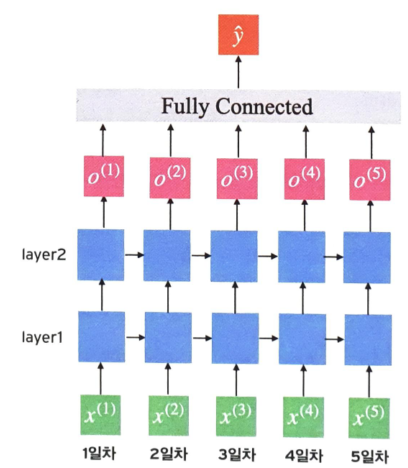

In [12]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [13]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [14]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [15]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [16]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0610
[epoch : 10] loss: 0.0037
[epoch : 20] loss: 0.0031
[epoch : 30] loss: 0.0029
[epoch : 40] loss: 0.0026


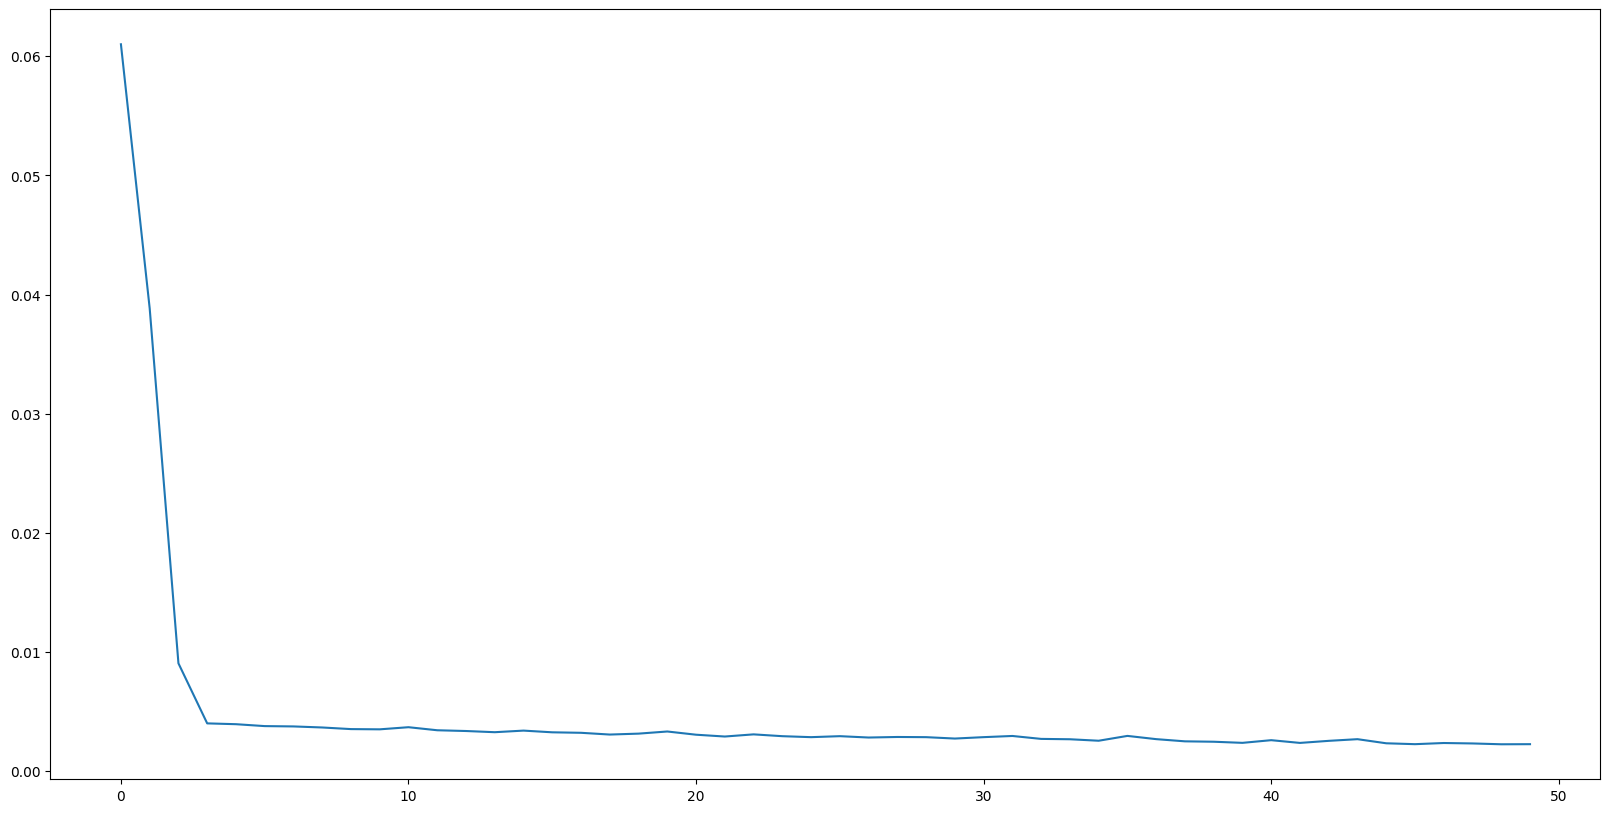

In [17]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [18]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

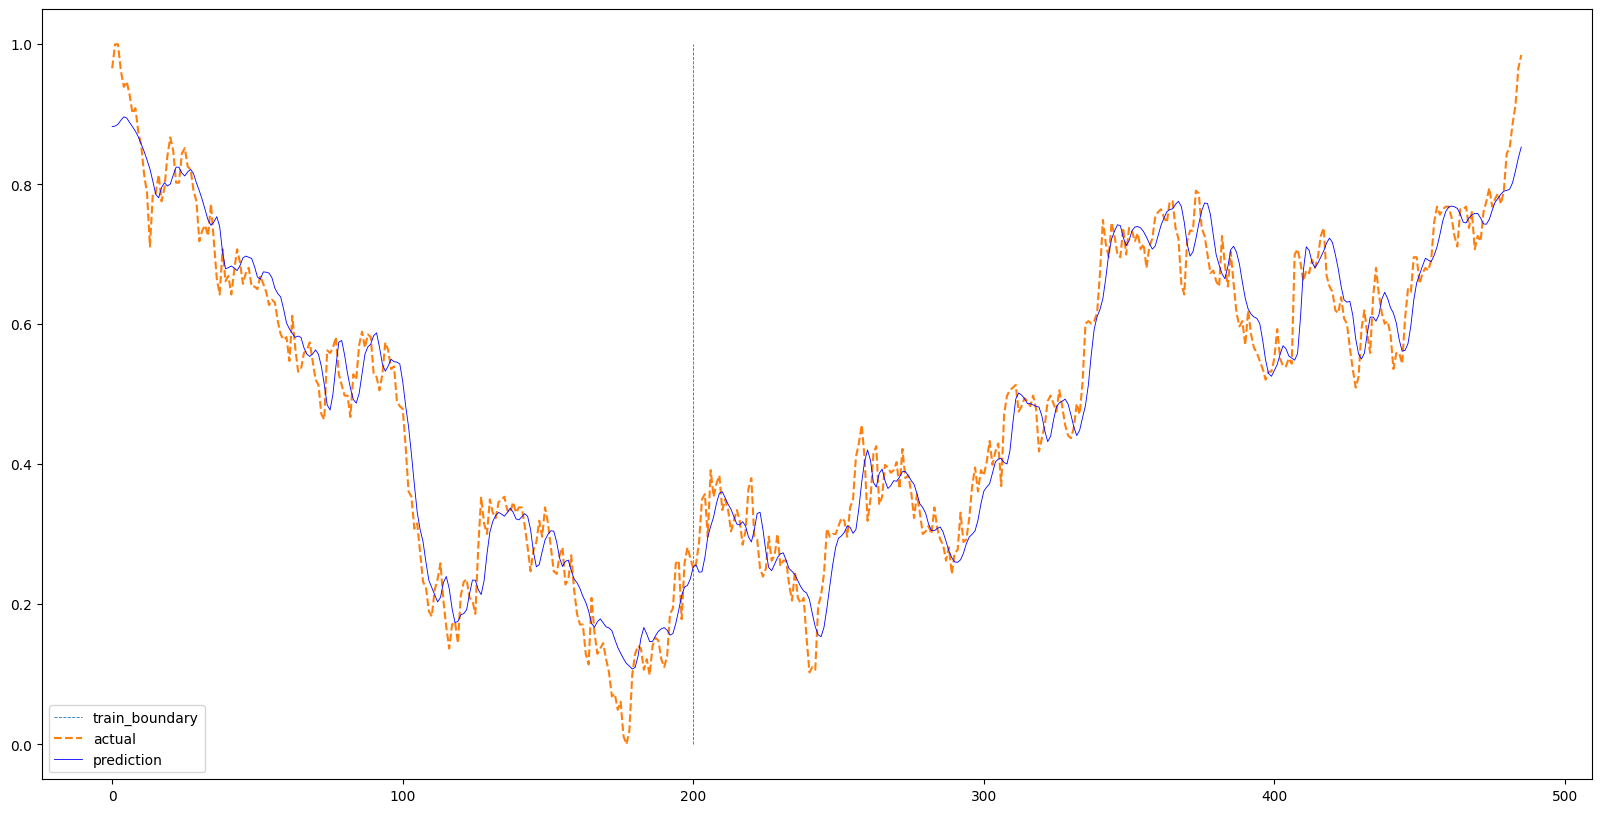

In [19]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [20]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [21]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [22]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [23]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [24]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.2115
[epoch: 10] loss: 0.0031
[epoch: 20] loss: 0.0027
[epoch: 30] loss: 0.0027
[epoch: 40] loss: 0.0026


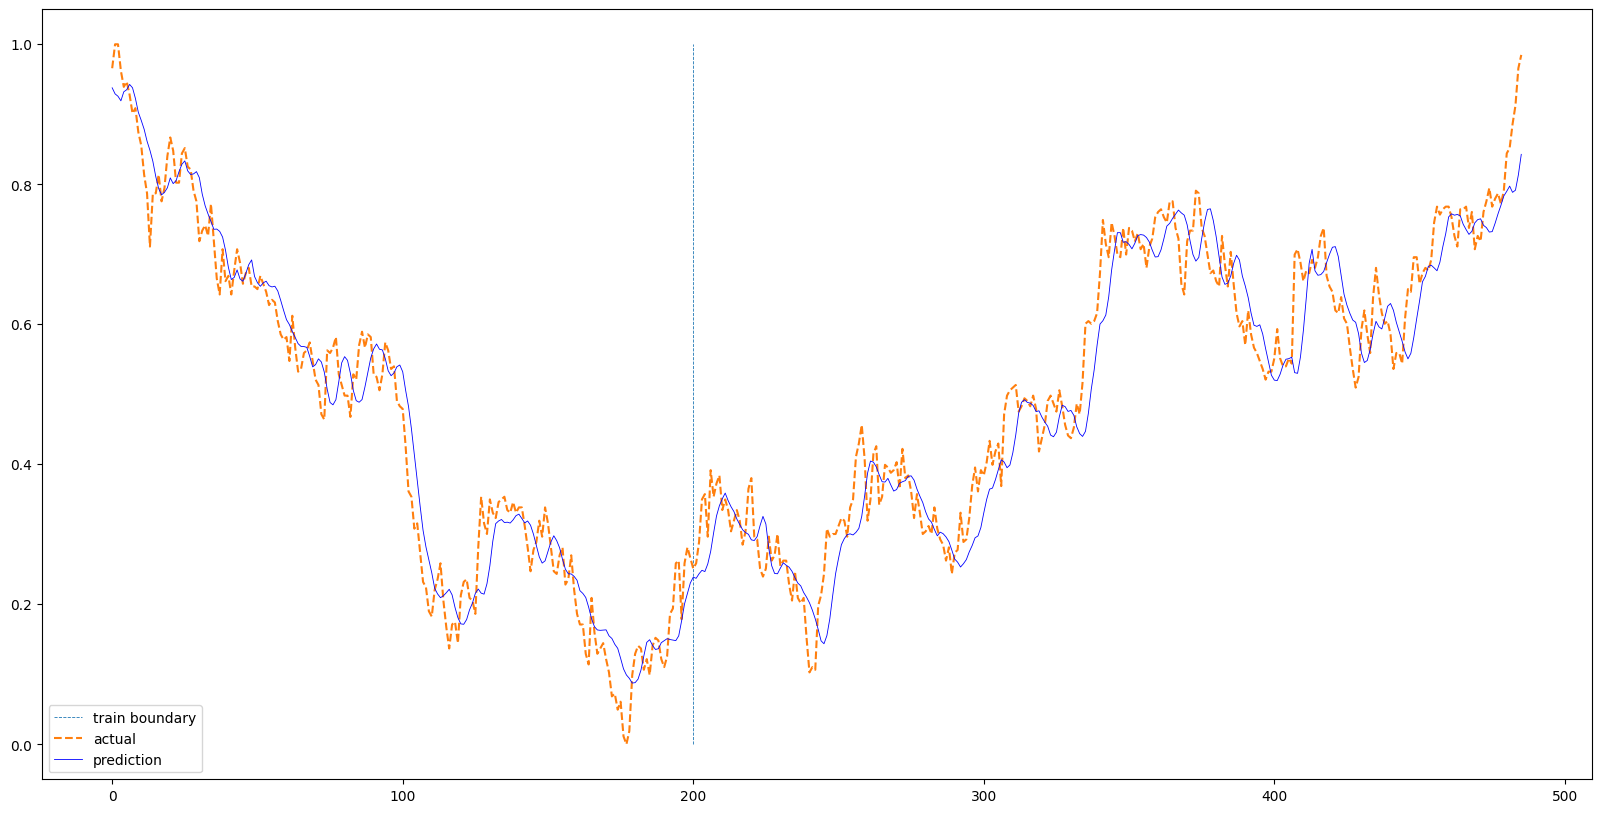

In [25]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# (Optional)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

In [28]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2021-01-01', '2024-12-31')
df.tail

<bound method NDFrame.tail of               Open    High     Low   Close    Volume    Change
Date                                                          
2021-01-04  194000  211000  193500  207500   5651695  0.080729
2021-01-05  207000  213000  205000  209500   3022595  0.009639
2021-01-06  209500  211500  202500  203000   2848547 -0.031026
2021-01-07  206000  210500  204500  206000   2478337  0.014778
2021-01-08  240500  257000  225000  246000  19933702  0.194175
...            ...     ...     ...     ...       ...       ...
2024-07-11  277000  278500  274500  278500    653458  0.014572
2024-07-12  277500  278500  268000  271500    666813 -0.025135
2024-07-15  273000  273500  267500  268500    541442 -0.011050
2024-07-16  270500  276000  270000  274500    552065  0.022346
2024-07-17  275500  275500  268000  268500    509678 -0.021858

[873 rows x 6 columns]>

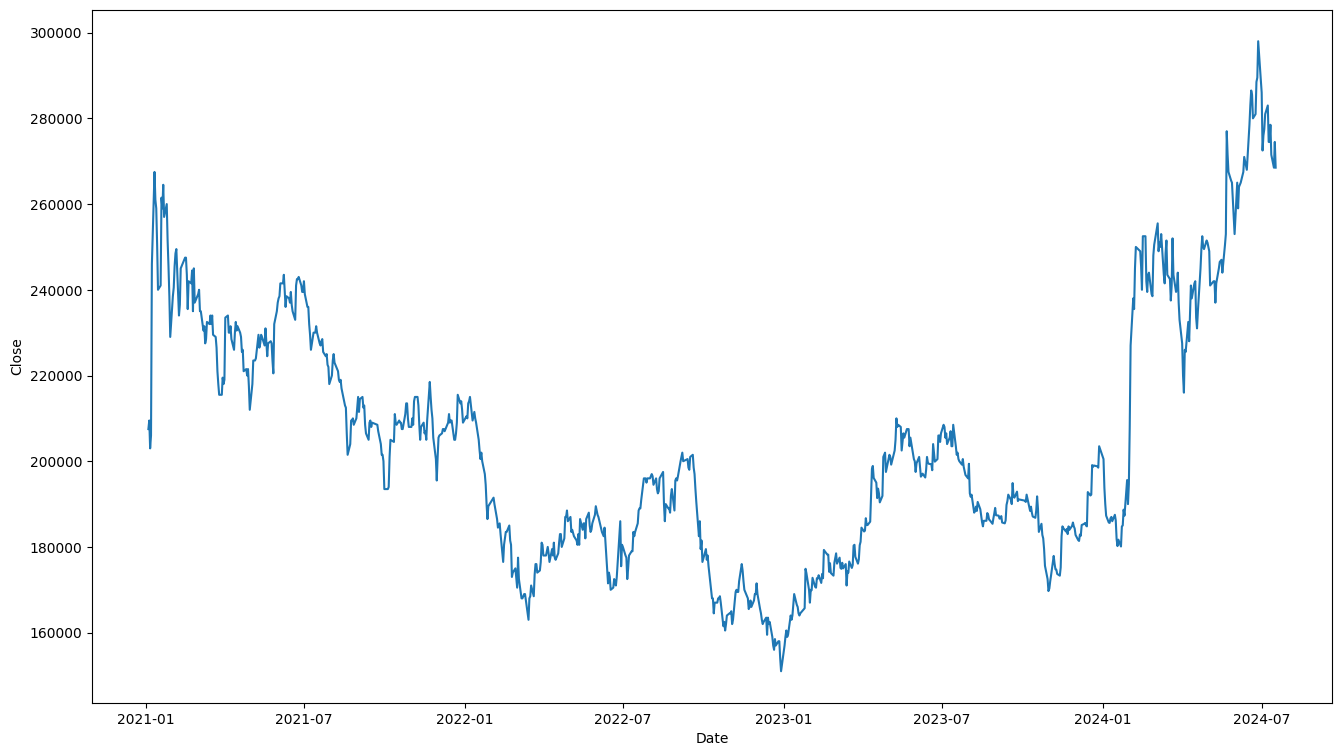

In [29]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

In [30]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])


In [31]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


In [32]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([668, 5, 4]) torch.Size([668, 1])


In [33]:
x_train_seq

tensor([[[0.2799, 0.3918, 0.3018, 0.2777],
         [0.3686, 0.4055, 0.3825, 0.1447],
         [0.3857, 0.3952, 0.3649, 0.1359],
         [0.3618, 0.3883, 0.3789, 0.1172],
         [0.5973, 0.7079, 0.5228, 1.0000]],

        [[0.3686, 0.4055, 0.3825, 0.1447],
         [0.3857, 0.3952, 0.3649, 0.1359],
         [0.3618, 0.3883, 0.3789, 0.1172],
         [0.5973, 0.7079, 0.5228, 1.0000],
         [0.7065, 0.9278, 0.7404, 0.7218]],

        [[0.3857, 0.3952, 0.3649, 0.1359],
         [0.3618, 0.3883, 0.3789, 0.1172],
         [0.5973, 0.7079, 0.5228, 1.0000],
         [0.7065, 0.9278, 0.7404, 0.7218],
         [0.7543, 0.8282, 0.7018, 0.3985]],

        ...,

        [[0.3857, 0.3918, 0.3895, 0.0310],
         [0.3686, 0.3814, 0.3895, 0.0102],
         [0.3720, 0.3986, 0.3895, 0.0247],
         [0.4096, 0.4158, 0.4105, 0.0314],
         [0.4198, 0.4192, 0.4351, 0.0225]],

        [[0.3686, 0.3814, 0.3895, 0.0102],
         [0.3720, 0.3986, 0.3895, 0.0247],
         [0.4096, 0.4158, 0.4105

In [34]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN


In [35]:
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8


In [36]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out


In [38]:

model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [39]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0092
[epoch : 10] loss: 0.0027
[epoch : 20] loss: 0.0020
[epoch : 30] loss: 0.0016
[epoch : 40] loss: 0.0014


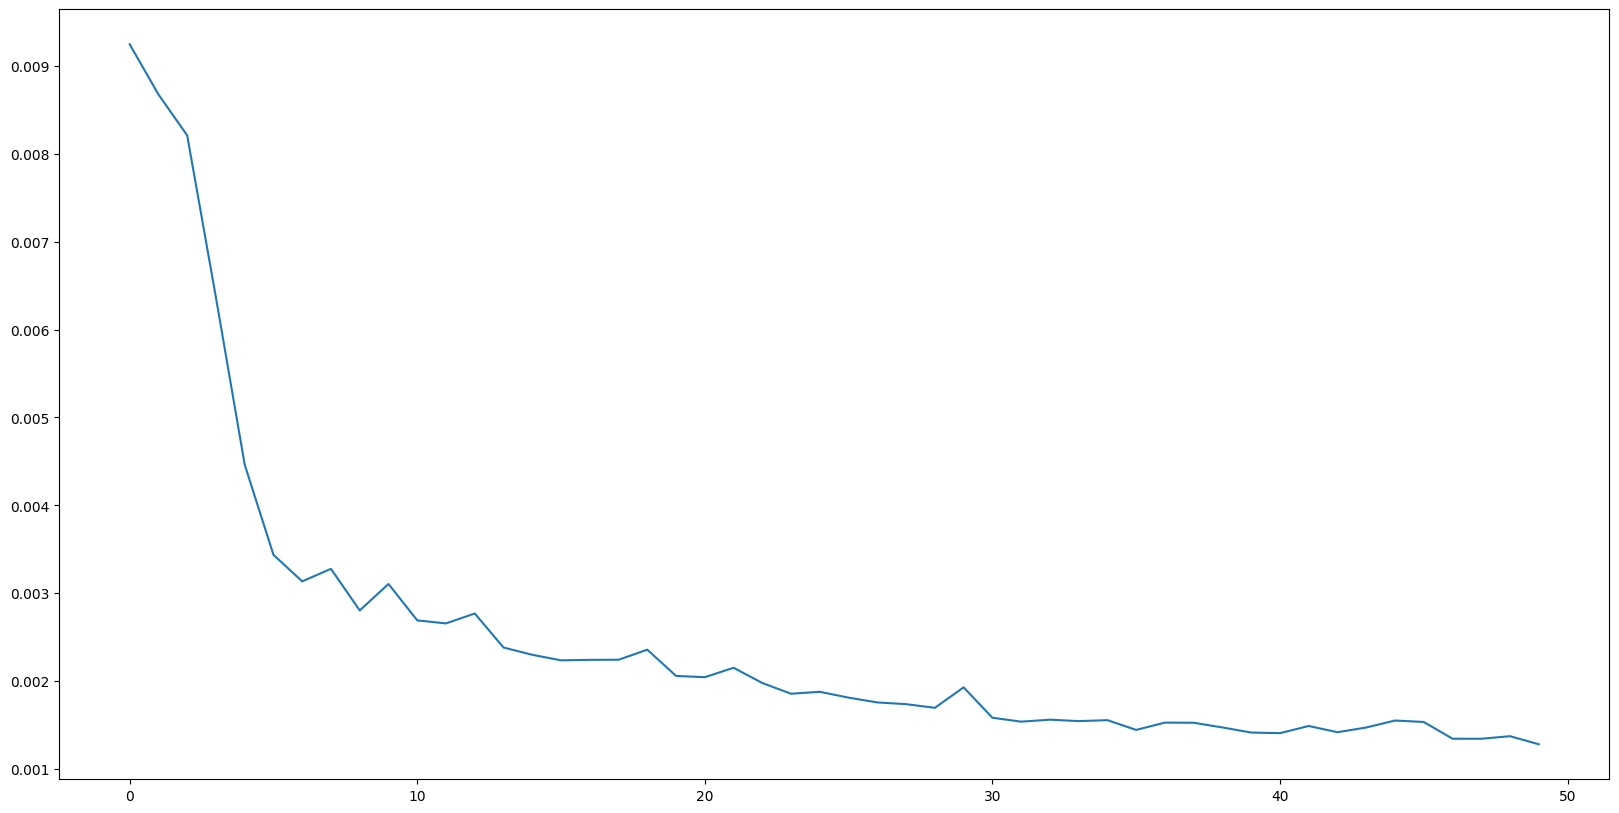

In [40]:

plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

In [41]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

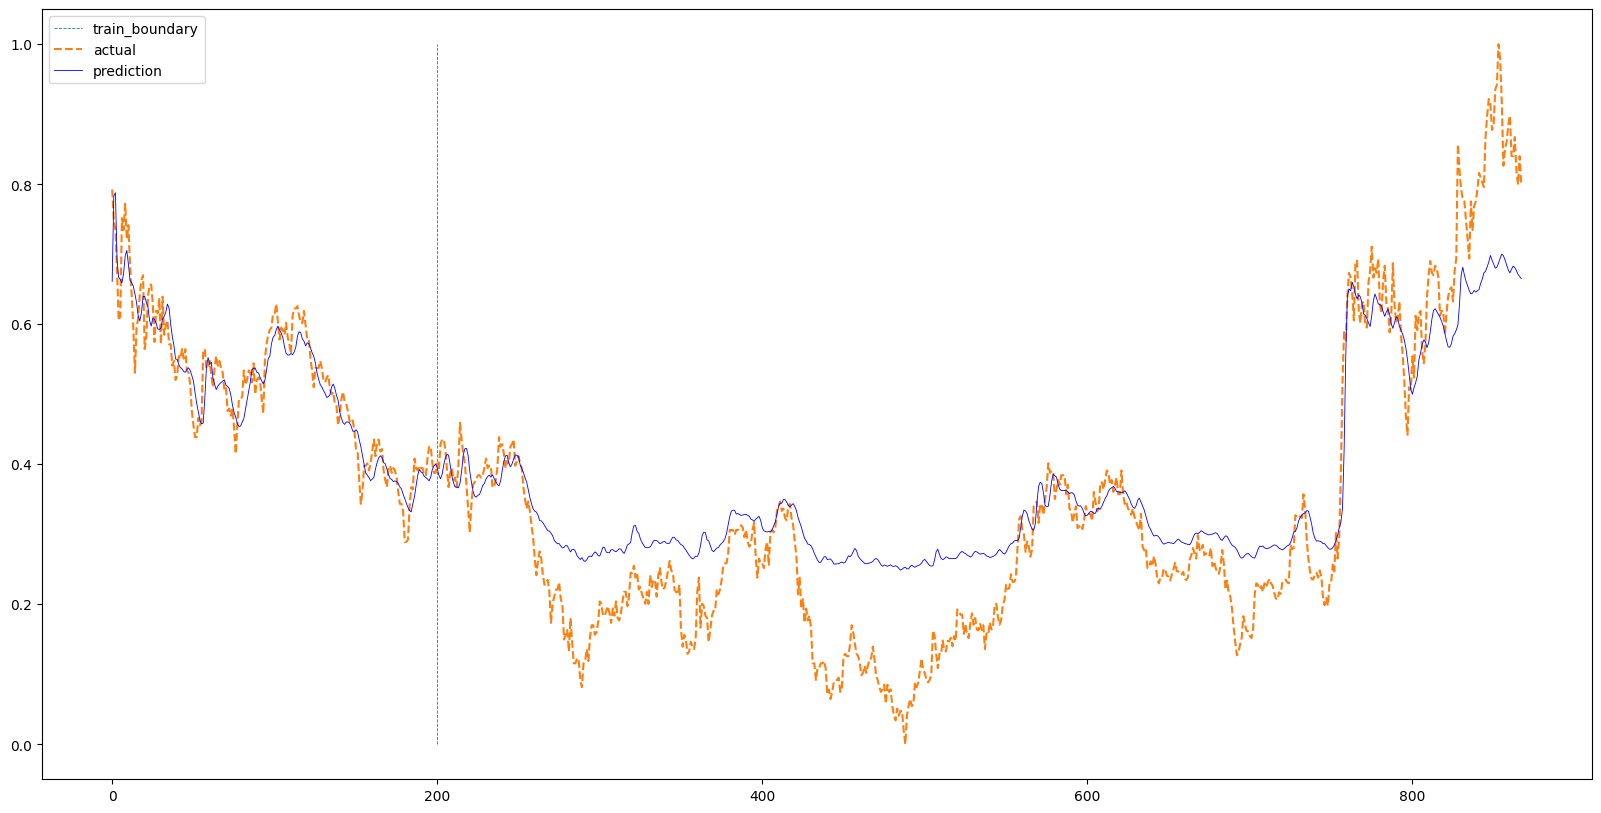

In [42]:

plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM

In [43]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8


class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out


model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [44]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.1777
[epoch: 10] loss: 0.0031
[epoch: 20] loss: 0.0029
[epoch: 30] loss: 0.0025
[epoch: 40] loss: 0.0021


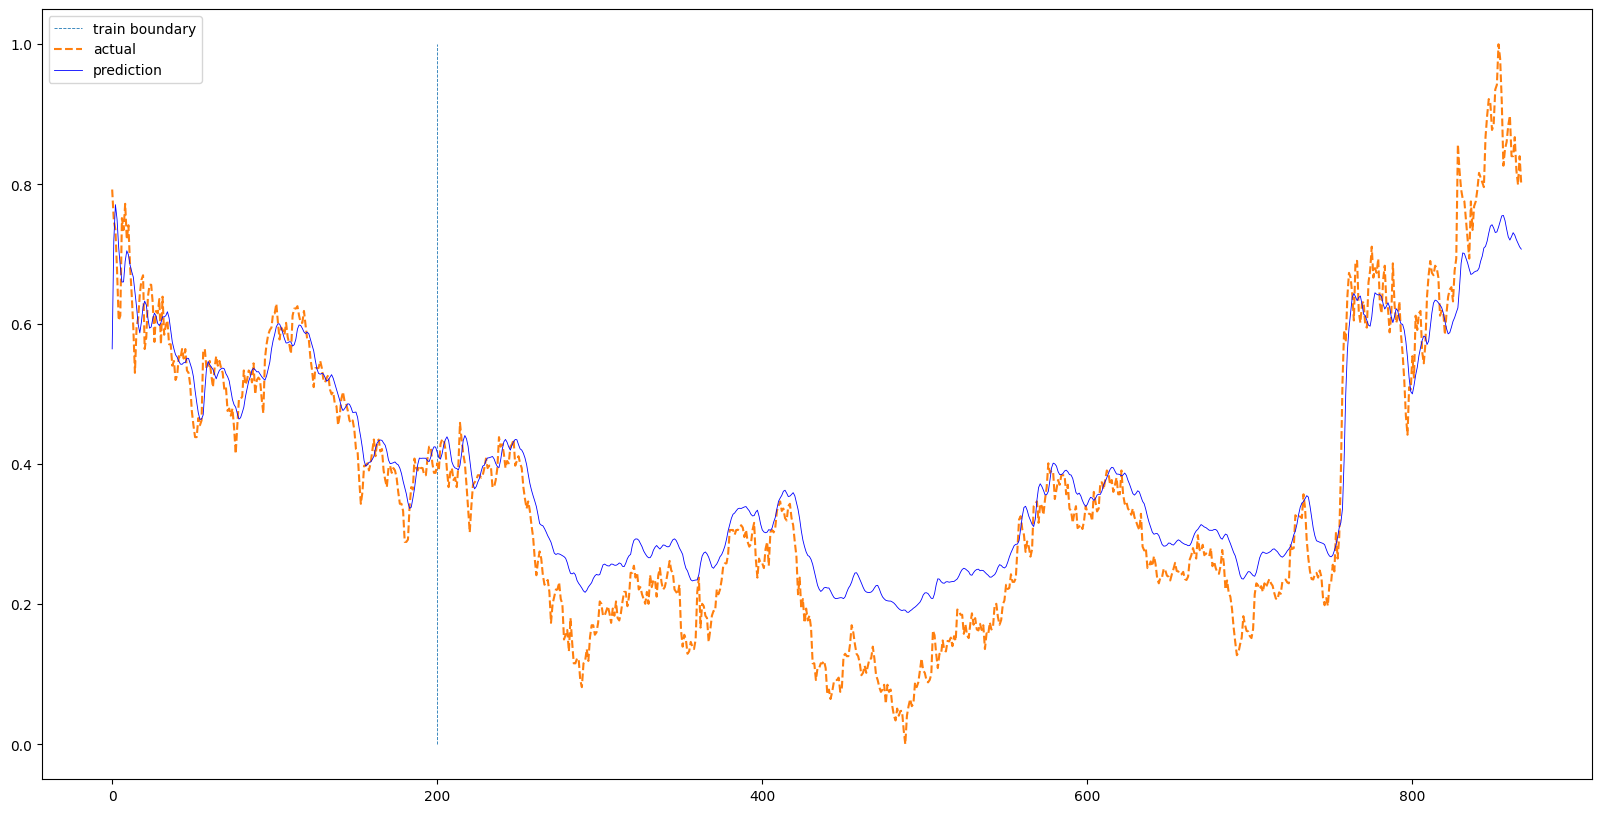

In [45]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# 해석

- Vanila RNN과 LSTM은 모두 대체적으로 잘 predict하고 있음을 보인다.
- 그렇지만 LSTM이 좀 더 예측을 더 잘하는 것으로 보여 성능이 더 좋아보인다.